In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
from importlib import reload
%load_ext tensorboard
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mutual_info_score
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
from scipy.stats import entropy
from scipy.signal import argrelextrema
from scipy.signal import find_peaks


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Update on 0812: Running Lorenz with newer versions of network module

In [110]:
t0 = 0
t1 = 100 
dt = 0.01
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([2, 5, 43]) ]
u_names = ['.']
pred = 100

# Abarbanel's parameters
sigma=16
rho=45.92
beta=4
lsys = embed_dynamics.LorenzFullStateD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
sys_list = [lsys]
sys_names = ['Lorenz']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*5, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['x','y','z']

In [239]:
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

In [233]:
# %load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
# Alternate code if you want to specify your own embeddings
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# opt_args = (0.005,) # Order: (Learning rate,)
activation = 'tanh' # 'leaky relu 0.2' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
# input_masks = [ [1] ] # Reminder: index 0 is time. Index 1 is first state.
input_masks = [ [1,3] ]
# input_masks = [[3]]
Nlayer = 2
Nneuron = 20
# tts = np.array([[10,20,30,40]])
tts = np.array([[10,20,30], [10,20,30]])
js,ts = delay_embed_converter_Garcia_Cao(False, tts)
de = 3
delay_int = 10 
net_listM = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
#     sys_list[i].pred = 10
    net_listM.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, min_tau=1, max_tau=100, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            delay_vars=(js, ts, tts),
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg#, opt_args=opt_args,
            , pred=0
        ))
    net_listM.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, loss='mse', pred=0, 
            de=de, delay_int=delay_int #, sym=True
        )
#         embed_dynamics.NN_Delay(
#             sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
#             Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
#             optimizer=opt_alg, loss='mse', pred=0, 
#             de=5, delay_int=-1
#         )
    )
# net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]
net_names = ['FNN', 'Delay']

Epoch = 20
# Construct models
for nn in net_listM:
    nn.construct()
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9970, 8, 1); outputset size = (9970, 3, 1)
Input set is masked by  [1, 3]
Train on 9970 samples
Epoch 1/20
9970/9970 [==============================] - 2s 250us/sample - loss: 0.2953
Epoch 2/20
9970/9970 [==============================] - 0s 49us/sample - loss: 0.1169
Epoch 3/20
9970/9970 [==============================] - 0s 50us/sample - loss: 0.0942
Epoch 4/20
9970/9970 [==============================] - 0s 47us/sample - loss: 0.0773
Epoch 5/20
9970/9970 [==============================] - 1s 56us/sample - loss: 0.0626
Epoch 6/20
9970/9970 [==============================] - 0s 49us/sample - loss: 0.0506
Epoch 7/20
9970/9970 [==============================] - 0s 41us/sample - loss: 0.0423
Epoch 8/20
9970/9970 [==============================] - 0s 36us/sample - loss: 0.0362
Epoch 9/20
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0316
Epoch 10/20
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0280
Epoch 11/20
9970/9970 [==

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


Train on 9980 samples
Epoch 1/20
9980/9980 [==============================] - 1s 84us/sample - loss: 0.2974
Epoch 2/20
9980/9980 [==============================] - 0s 33us/sample - loss: 0.1131
Epoch 3/20
9980/9980 [==============================] - 0s 31us/sample - loss: 0.0916
Epoch 4/20
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0761
Epoch 5/20
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0633
Epoch 6/20
9980/9980 [==============================] - 0s 34us/sample - loss: 0.0529
Epoch 7/20
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0447
Epoch 8/20
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0384
Epoch 9/20
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0334
Epoch 10/20
9980/9980 [==============================] - 0s 35us/sample - loss: 0.0295
Epoch 11/20
9980/9980 [==============================] - 0s 41us/sample - loss: 0.0262
Epoch 12/20
9980/9980 [=======

In [152]:
for nn in net_listM:
    nn.train(epoch=100, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9970, 8, 1); outputset size = (9970, 3, 1)
Input set is masked by  [1, 3]
Train on 9970 samples
Epoch 1/100
9970/9970 [==============================] - 1s 62us/sample - loss: 402.68670s - loss: 405.251
Epoch 2/100
9970/9970 [==============================] - 0s 44us/sample - loss: 308.8119
Epoch 3/100
9970/9970 [==============================] - 0s 42us/sample - loss: 240.5503
Epoch 4/100
9970/9970 [==============================] - 0s 43us/sample - loss: 191.1890
Epoch 5/100
9970/9970 [==============================] - 0s 40us/sample - loss: 152.9754
Epoch 6/100
9970/9970 [==============================] - 0s 46us/sample - loss: 121.3099
Epoch 7/100
9970/9970 [==============================] - 0s 40us/sample - loss: 96.5021
Epoch 8/100
9970/9970 [==============================] - 0s 39us/sample - loss: 77.0466
Epoch 9/100
9970/9970 [==============================] - 0s 37us/sample - loss: 61.7204
Epoch 10/100
9970/9970 [==============================] - 0s 37us/sampl

In [14]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title='', maxtime=None):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate, maxtime=maxtime
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
    fig.suptitle(title)
    return fig, axs, results_list

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1, maxtime=None):
    if maxtime is None:
        maxtime = len(time)
    else:
        maxtime = int(maxtime)
#         axs.plot(time[::skip], data[::skip])
#     else:
#         axs.plot(time[:maxtime:skip], data[:maxtime:skip])
    axs.plot(time[:maxtime:skip], data[:maxtime:skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[:maxtime:skip], data2[:maxtime:skip])
#         if maxtime is None:
#             axs.plot(time[::skip], data2[::skip])
#         else:
#             axs.plot(time[:maxtime:skip], data[:maxtime:skip])
        
        axs.legend(leglist)
    return axs

Dimensions: Outputset = (9970, 3, 1), results = (9970, 3, 1)


/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


<Figure size 432x288 with 0 Axes>

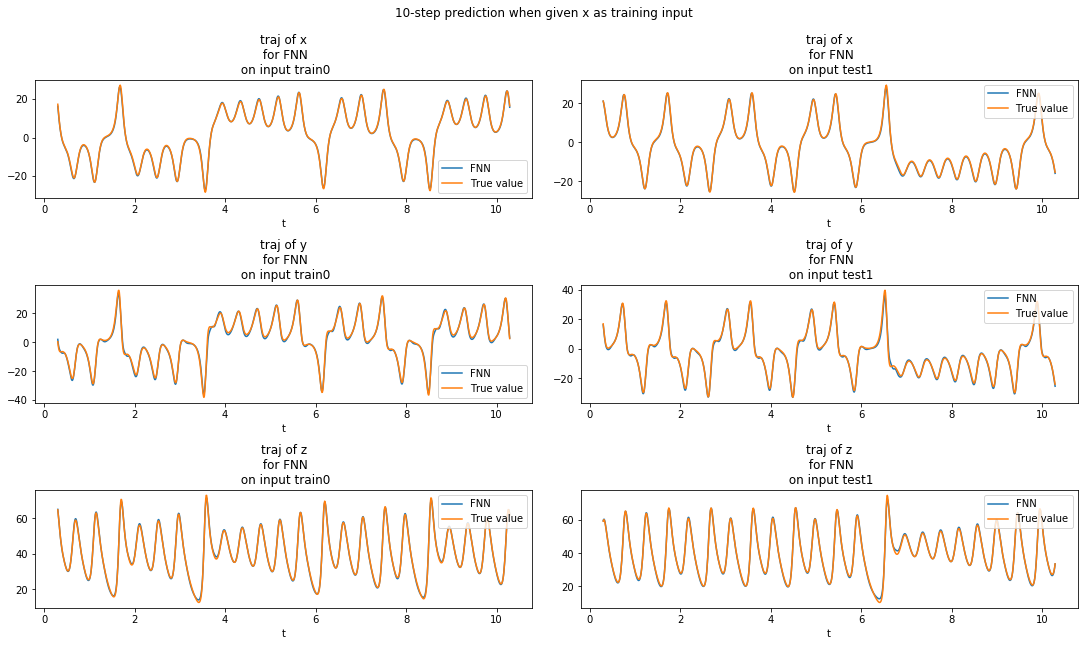

In [241]:
fig, axs, rlist0 = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[0], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=10/dt,
                       title='10-step prediction when given x as training input\n' )

Dimensions: Outputset = (9970, 3, 1), results = (9970, 3, 1)


<Figure size 432x288 with 0 Axes>

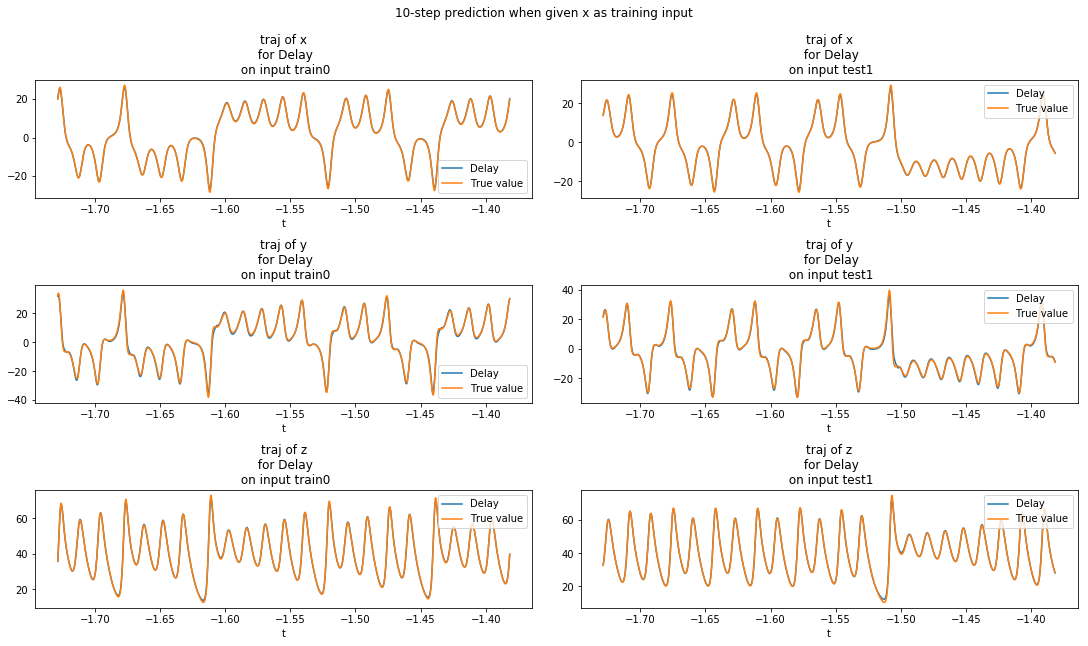

In [242]:
fig, axs, rlist1 = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=10/dt,
                       title='10-step prediction when given x as training input\n' )

In [ ]:
# Plots the test dataset with very long time range
fig, axs, _ = plot_tests( test_inds=[2], net_list=net_listM, net_inds=[0], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=97, 
                       title='10-step prediction when given x as training input\n' )

In [162]:
rlist0[0][2][0].shape, rlist0[1][2][0].shape

((9970, 8, 1), (9970, 2, 4))

In [167]:
rlist0[0][2][0][:,1,0], rlist0[1][2][0][:,0,1]

(array([0.34942726, 0.40892313, 0.47903369, ..., 0.63741424, 0.445214  ,
        0.27552609]),
 array([5.68126231, 6.4311426 , 7.31480938, ..., 9.31102277, 6.88854926,
        4.74981912]))

In [170]:
rlist0[0][1][0][:,1,0] == rlist0[1][1][0][:,1,0]

array([ True,  True,  True, ...,  True,  True,  True])

In [175]:
rlist2 = [net_listM[0].model.predict(inputset.reshape(-1,8,1)) for inputset in rlist0[1][2]]

In [178]:
np.linalg.norm(rlist0[1][0][1] - rlist2[1])

0.0

In [163]:
rlist0[0][0][0], rlist0[1][0][0]

(array([[[ 6.778651  ],
         [ 5.728178  ],
         [ 1.0349474 ]],
 
        [[ 5.711195  ],
         [ 4.454198  ],
         [ 0.91735077]],
 
        [[ 4.5724936 ],
         [ 3.1297545 ],
         [ 0.9416816 ]],
 
        ...,
 
        [[-0.45307308],
         [-0.5238231 ],
         [-1.7731175 ]],
 
        [[-0.5879139 ],
         [-0.5437243 ],
         [-3.0012507 ]],
 
        [[-0.7160847 ],
         [-0.6084371 ],
         [-3.9818792 ]]], dtype=float32), array([[[ 17.36515  ],
         [  0.6312018],
         [ 64.86748  ]],
 
        [[ 14.721169 ],
         [ -2.6232696],
         [ 62.08531  ]],
 
        [[ 11.93845  ],
         [ -4.8138986],
         [ 58.99378  ]],
 
        ...,
 
        [[-11.280251 ],
         [-16.333494 ],
         [ 32.713966 ]],
 
        [[-12.058841 ],
         [-17.445585 ],
         [ 33.04771  ]],
 
        [[-12.717398 ],
         [-18.3771   ],
         [ 33.480778 ]]], dtype=float32))

In [179]:
def normalize_local(data, axis, params=None, reverse=False):
    # Arguments:
    # data - the input data; could be of any shape
    # axis - the only axis that should be preserved; i.e. the axis that represents Nfeatures
    # params - a tuple (mean, variance) to use for data, where each element should have Nfeatures values.
    #          If params=None, then the system finds the mean and variance by itself.
    # reverse - whether we want normalization or de-normalization. When reverse is True, params should not be None.
    Nfeats = data.shape[axis]
    if params is None:
        # https://numpy.org/doc/stable/reference/generated/numpy.moveaxis.html#numpy.moveaxis
        X = np.moveaxis(data, axis, 0).reshape(Nfeats, -1)
        params = ( np.mean(X, axis=1), np.std(X, axis=1) )
        if reverse:
            print('Normalize() method warning: Nonsensical input combination. If you want reverse, you should provide params.')
#     print(params)
#     print('axis {0} is the main axis. There are {1} variables along it. Whole data size is {2}.'.format(axis, Nfeats, data.shape))
#     '''
    data = np.swapaxes(data, axis, 0)
#     data = np.moveaxis(data, axis, 0)
#     print('The parameters have size {0}, so we resized the data into {1} for computation.'.format(params[0].shape, data.shape))
    if reverse:
        for i in range(Nfeats):
            data[i] = data[i] * params[1][i] + params[0][i]
    else:
        for i in range(Nfeats):
            data[i] = (data[i] - params[0][i]) / params[1][i]
    data = np.swapaxes(data, 0, axis)
#     data = np.moveaxis(data, 0, axis)
#     '''
#     print('Turned data back to its original shape {0} and finishing the method.'.format(data.shape))
    return data, params

In [184]:
normalize_local(rlist0[1][2][0], axis=1, params=net_listM[0].input_norm_params) # The printout is after normalization

(array([[[ 0.29537557,  0.34942726,  1.48350967,  1.27040994],
         [ 1.87968153,  1.36909818,  2.75251438,  5.02694133]],
 
        [[ 0.24278103,  0.40892313,  1.63884482,  1.05272361],
         [ 1.80375787,  1.36194888,  3.18185214,  4.81099226]],
 
        [[ 0.20900299,  0.47903369,  1.77831485,  0.84011205],
         [ 1.73362144,  1.37073168,  3.65341842,  4.58219894]],
 
        ...,
 
        [[ 1.91546861,  0.63741425, -0.43979891, -0.92870425],
         [ 4.07406756,  4.4135612 ,  2.90787256,  2.47823013]],
 
        [[ 1.99766275,  0.445214  , -0.48534647, -0.99732114],
         [ 4.5657042 ,  4.19230213,  2.81871366,  2.51436119]],
 
        [[ 2.02389228,  0.27552609, -0.52835596, -1.07089104],
         [ 4.97850283,  3.98989607,  2.73799246,  2.57216902]]]),
 (array([ 1.27711457,  1.28902401,  1.27610314,  1.24376089, 40.07379744,
         40.11511276, 40.13487202, 40.11082699]),
  array([12.60390438, 12.61435809, 12.61078217, 12.59508916, 13.46014321,
         13.4

In [182]:
normalize_local(rlist0[1][2][0], axis=1, params=(
    np.array([ 1.27150066, 40.1086523 ]), np.array([12.60604679, 13.45627401])), reverse=True)

(array([[[  5.        ,   5.68126231,  19.97512857,  17.28924003],
         [ 25.        ,  18.55931874,  36.010226  ,  64.70066207]],
 
        [[  4.33710344,   6.4311426 ,  21.93295792,  14.54554235],
         [ 24.04227173,  18.46913493,  41.42604628,  61.97660314]],
 
        [[  3.91136824,   7.31480938,  23.69082492,  11.86580657],
         [ 23.1575457 ,  18.57992427,  47.37455218,  59.09052234]],
 
        ...,
 
        [[ 25.41949772,   9.31102277,  -4.2660689 , -10.42818494],
         [ 52.6807711 ,  56.96326542,  37.96996981,  32.55030635]],
 
        [[ 26.45546483,   6.88854927,  -4.84014597, -11.29302575],
         [ 58.88245174,  54.17222429,  36.84528751,  33.00607642]],
 
        [[ 26.78605938,   4.74981912,  -5.38223346, -12.2202937 ],
         [ 64.08964153,  51.61900178,  35.82704136,  33.73528507]]]),
 (array([ 1.27150066, 40.1086523 ]), array([12.60604679, 13.45627401])))

In [183]:
rlist0[1][2][0]

array([[[  5.        ,   5.68126231,  19.97512857,  17.28924003],
        [ 25.        ,  18.55931874,  36.010226  ,  64.70066207]],

       [[  4.33710344,   6.4311426 ,  21.93295792,  14.54554235],
        [ 24.04227173,  18.46913493,  41.42604628,  61.97660314]],

       [[  3.91136824,   7.31480938,  23.69082492,  11.86580657],
        [ 23.1575457 ,  18.57992427,  47.37455218,  59.09052234]],

       ...,

       [[ 25.41949772,   9.31102277,  -4.2660689 , -10.42818494],
        [ 52.6807711 ,  56.96326542,  37.96996981,  32.55030635]],

       [[ 26.45546483,   6.88854927,  -4.84014597, -11.29302575],
        [ 58.88245174,  54.17222429,  36.84528751,  33.00607642]],

       [[ 26.78605938,   4.74981912,  -5.38223346, -12.2202937 ],
        [ 64.08964153,  51.61900178,  35.82704136,  33.73528507]]])

In [243]:
rlist3 = net_listM[0].test([0,1,2])
rlist3[2][0][:,1,0]

Dimensions: Outputset = (9970, 3), results = (9970, 3)


array([0.34819356, 0.40764013, 0.47769259, ..., 0.63594189, 0.44390093,
       0.27435364])

In [244]:
inputsets = [normalize( inputset[net_listM[0].input_mask,:], axis=0,
                        params=net_listM[0].input_norm_params)[0] for inputset in net_listM[0].dynamics.Inputset]
rlist4,_,_ = net_listM[0].delay_embed_fnn(inputsets)

rlist4[0][:,1,0]

array([0.34942726, 0.40892313, 0.47903369, ..., 0.63741424, 0.445214  ,
       0.27552609])

In [245]:
rlist5 = net_listM[1].test([0,1,2])
rlist5[2][0][:,0,1]

array([ 0.34897144,  0.40844523,  0.47852976, ..., -0.43996177,
       -0.48549242, -0.52848595])

In [214]:
ip0, op0 = net_listM[0].train_data_generation_helper([0])
ip1, op1 = net_listM[1].train_data_generation_helper([0])

Inputset size = (9970, 8, 1); outputset size = (9970, 3, 1)
Input set is masked by  [1, 3]


In [215]:
for i in range(2):
    for j in range(3):
        print(ip0[:,i*4+j,0])
        print(ip1[:-10,i,j])
        print(np.linalg.norm(ip0[:,i*4+j,0] - ip1[:-10,i,j]))

[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
0.0
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
0.0
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
0.0
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
0.0
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
0.0
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
0.0


In [148]:
np.reshape(ip1[0,:,:], (6,)), ip0[0,:,:]

(array([ 5.        ,  5.68126231, 19.97512857, 25.        , 18.55931874,
        36.010226  ]), array([[ 5.        ],
        [ 5.68126231],
        [19.97512857],
        [17.28924003],
        [25.        ],
        [18.55931874],
        [36.010226  ],
        [64.70066208]]))

In [146]:
for j in range(3):
    print(op0[:,j,0])
    print(op1[10:,j,0])
    print(np.linalg.norm(op0[:,j,0]-op1[10:,j,0]))

[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
0.0
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
0.0
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
0.0


In [150]:
net_listM[1].input_reshape

(6,)

In [17]:
net_listM[0].Inputset[0].shape
# net_listM[0].input_mask
# net_listM[0].Inputset[0][:,net_listM[0].input_mask,:].shape
# net_listM[0].de

(9970, 8, 1)

In [18]:
net_listM[1].Inputset[0][:,input_masks[0]].shape
# net_listM[1].input_shape

(9980, 2, 3)

In [120]:
net_listM[0].Inputset[0][:9970,0,0]

array([ 5.        ,  4.33710343,  3.91136823, ..., 25.41949772,
       26.45546483, 26.78605938])

In [119]:
np.mean(net_listM[0].Inputset[0], axis=0)

array([[ 1.27711457],
       [ 1.28902401],
       [ 1.27610314],
       [ 1.24376089],
       [40.07379744],
       [40.11511276],
       [40.13487202],
       [40.11082699]])

In [121]:
# net_listM[0].Inputset[0][:9970,6,0], net_listM[1].Inputset[0][:,input_masks[0]][:9970,1,2]
for i in range(2):
    for j in range(3):
        print( np.all( net_listM[0].Inputset[0][:9970,i*4+j,0] == net_listM[1].Inputset[0][:,input_masks[0]][:9970,i,j] ) )

True
True
True
True
True
True


In [122]:
net_listM[0].input_norm_params, net_listM[1].input_norm_params

((array([ 1.27711457,  1.28902401,  1.27610314,  1.24376089, 40.07379744,
         40.11511276, 40.13487202, 40.11082699]),
  array([12.60390438, 12.61435809, 12.61078217, 12.59508916, 13.46014321,
         13.4675748 , 13.45557051, 13.44172193])),
 (array([49.995     ,  1.28122637,  1.27197595, 40.11371604,  0.        ]),
  array([28.80989399, 12.60858468, 14.41689053, 13.46205322,  0.        ])))

In [86]:
len(net_listM[0].Inputset)

3

In [123]:
Inputset00 = np.concatenate(net_listM[0].Inputset)
Outputset00 = np.concatenate(net_listM[0].Outputset)
Inputset00, params0o = normalize_frame(Inputset00)
Outputset00, params0i = normalize_frame(Outputset00)

Inputset11 = np.concatenate(net_listM[1].Inputset)
Outputset11 = np.concatenate(net_listM[1].Outputset)
Inputset11, params1o = normalize_frame(Inputset11)
Outputset11, params1i = normalize_frame(Outputset11)
Inputset11 = Inputset11[:,[1,3],:]

In [124]:
innnnp = np.concatenate(net_listM[0].Inputset)
innnnp.shape

(69910, 8, 1)

In [125]:
np.mean(innnnp, axis=0)

array([[ 0.45361213],
       [ 0.45474202],
       [ 0.44764398],
       [ 0.43432825],
       [40.19535163],
       [40.20393836],
       [40.20987941],
       [40.20395038]])

In [126]:
Inputset00.shape, Inputset11.shape, Outputset00.shape, Outputset11.shape

((69910, 8, 1), (69940, 2, 3), (69910, 3, 1), (69940, 3, 1))

In [127]:
params0o, params0i, params1o, params1i

((array([ 0.45361213,  0.45474202,  0.44764398,  0.43432825, 40.19535163,
         40.20393836, 40.20987941, 40.20395038]),
  array([12.67343713, 12.67584886, 12.67617936, 12.67072034, 13.33930715,
         13.34076617, 13.3374043 , 13.33652559])),
 (array([ 0.43432825,  0.42706924, 40.20395038]),
  array([12.67072034, 14.40952321, 13.33652559])),
 (array([192.917505  ,   0.45052762,   0.44647189,  40.20358099,
           0.        ]),
  array([152.54635653,  12.67486417,  14.41637739,  13.33976782,
           0.        ])),
 (array([ 0.44352948,  0.43695569, 40.20943494]),
  array([12.67597153, 14.41545604, 13.33862253])))

In [128]:
for i in range(2):
    for j in range(3):
        print( Inputset00[:9970,i*4+j,0])
        print( Inputset11[:9970,i,j] )
        print( np.linalg.norm( Inputset00[:9970,i*4+j,0] - Inputset11[:9970,i,j] ) )

[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
0.0
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
0.0
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
0.0
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
0.0
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
0.0
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
0.0


In [129]:
for j in range(3):
    print( Outputset00[:9970,j,0])
    print( Outputset11[10:9980,j,0] )
    print( np.linalg.norm( Outputset00[:9970,j,0] - Outputset11[10:9980,j,0] ) )

[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
0.0
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
0.0
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
0.0


In [ ]:
# isinstance(tf.keras.losses.mean_squared_error, callable)
# hasattr(tf.keras.losses.mean_squared_error, '__call__')
# type(tf.keras.losses.mean_squared_error)

# rlist[0]: Results that didn't work. Comes from net_listM[0] using NN_FNN.
# rlist[1]: Results that did work. Comes from net_listM[1] using NN_Delay.
# Compare their values previous to normalization, and see what's wrong here.
# net_listM[0].input_norm_params[1], net_listM[1].input_norm_params[1][input_masks[0]]
# net_listM[0].output_norm_params, net_listM[1].output_norm_params
rlist[0][0][0][:,2,0], rlist[1][0][0][:,2,0] # This line checks prediction values of the not-working net ([0])
# and the working net ([1])'s prediction ([0]) on the first dynamics data ([0]) for the 3rd variable (2).
# Note: rlist[0]'s time starts at 0.3, while rlist[1] starts at 0.2. Make sure you start rlist[1] 10 samples later.

# rlist[0][2][0].shape, rlist1[1][2][0].shape
# net_listM[0].Inputset[0][:9970,6,0], net_listM[1].Inputset[0][:,input_masks[0]][:9970,1,2] # Compare input sets
# i00 = np.concatenate(net_listM[0].Inputset)
# i11 = np.concatenate(net_listM[1].Inputset)
i00.shape, i11.shape
# i00[:9000, 0, 0], i11[10:9010, 1, 0]
# i00, i11
i00[:9000, 0, 0], i11[0:9000, 1, 0]

# rlist[0][2][0][:,6,0], rlist[1][2][0][10:,1,2] # Compare their inputs
# r00 = normalize(rlist[0][2][0], axis=1, params=net_listM[0].input_norm_params)[0]
# r11 = normalize(rlist[1][2][0], axis=1, params=net_listM[1].input_norm_params)[0]
# r00[:,6,0], rlist[0][2][0][:,6,0], r11[10:,1,2], rlist[1][2][0][10:,1,2]
# rlist[0][2][0][0], rlist1[1][2][0][0]
# np.all(rlist[0][2][0][:9970,0,0] == rlist1[1][2][0][:9970,0,0]) # Check that they have the same Inputset ([2])
# rlist[0][2][0][:1000,0,0], rlist[1][2][0][:1000,0,0]
# np.all(rlist[0][0][0] == rlist1[1][0][0]) # Check that they have the same result/prediction
# np.all(rlist[0][1][0] == rlist1[1][1][0]) # Check that they have the same Outputset ([1])
# np.all(rlist[0][3][0] == rlist1[1][3][0]) # Check that they have the same Timeset ([3])
# rlist[0][3][0][:1000], rlist[1][3][0][:1000]
# np.all(rlist[0][0][2] == rlist1[1][0][2])
# np.linalg.norm( rlist1[0][0][0] - rlist1[0][1][0] ) # Difference between prediction ([0]) and actual outcome ([1])
# np.linalg.norm( rlist[0][0][0] - rlist[0][1][0] )

# fig,axs = plt.subplots(1, 1, constrained_layout=True, figsize = (4,3), squeeze=False)
# n, nn, j, jj, i, ii = (0,0,0,0,0,0)
# time_series = np.squeeze(rlist[nn][3][jj])
# # result = np.square(rlist[nn][0][jj] - rlist[nn][1][jj])
# result = rlist[nn][0][jj]
# make_axs_plot(      axs = axs[0][0], time = time_series, data = result[:,ii],
#                     title = '???',
#                     datatype = 'traj', data2 = rlist[nn][1][jj][:,ii], 
#                     leglist = [net_names[nn], 'True value'], skip = 1, maxtime=1000
#                 )

In [130]:
inputsets0 = [normalize( inputset[net_listM[0].input_mask,:], axis=0,
                                params=net_listM[0].input_norm_params)[0] for inputset in net_listM[0].dynamics.Inputset]

In [96]:
print(net_listM[0].dynamics.Inputset[0][net_listM[0].input_mask,:], net_listM[0].dynamics.Inputset[0].shape)

[[  5.           4.33710343   3.91136823 ... -10.42818494 -11.29302575
  -12.2202937 ]
 [ 25.          24.04227173  23.1575457  ...  32.55030635  33.00607642
   33.73528507]] (5, 10000)


In [102]:
print(inputsets0[0])

[[ 0.29537557  0.24278103  0.20900299 ... -0.92870425 -0.99732114
  -1.07089104]
 [ 1.87968153  1.80375787  1.73362144 ...  2.47823013  2.51436119
   2.57216902]]


In [105]:
normalize(net_listM[0].dynamics.Inputset[0][net_listM[0].input_mask,:],0)

(array([[ 0.29533762,  0.24272941,  0.20894259, ..., -0.92906029,
         -0.99769502, -1.07128403],
        [-1.12094339, -1.19208134, -1.25779684, ..., -0.56012327,
         -0.52626967, -0.47210566]]),
 (array([ 1.27855998, 40.091231  ]), array([12.60062996, 13.46297331])))

In [97]:
inputsets1,_ = delay_embed(net_listM[1].delay_int, net_listM[1].de, 
                                    net_listM[1].dynamics.Inputset, net_listM[1].dynamics.Outputset, net_listM[1].pred)

In [100]:
print(inputsets1[0].shape, inputsets1[0][:,[1,3],:])

(9980, 5, 3) [[[  5.           5.68126231  19.97512857]
  [ 25.          18.55931874  36.010226  ]]

 [[  4.33710343   6.4311426   21.93295792]
  [ 24.04227173  18.46913493  41.42604629]]

 [[  3.91136823   7.31480938  23.69082492]
  [ 23.1575457   18.57992426  47.37455218]]

 ...

 [[  9.31102277  -4.2660689  -10.42818494]
  [ 56.96326542  37.96996981  32.55030635]]

 [[  6.88854926  -4.84014597 -11.29302575]
  [ 54.17222429  36.84528751  33.00607642]]

 [[  4.74981912  -5.38223347 -12.2202937 ]
  [ 51.61900179  35.82704136  33.73528507]]]


In [74]:
print(inputsets0[0]) # [x(t); z(t)], normalized individually straight from dynamics.Inputset
print(Inputset00[:,0]) # normalized from nn.Inputset, which is obtained from delay embedded dynamics.Inputset

[[ 0.29537557  0.24278103  0.20900299 ... -0.92870425 -0.99732114
  -1.07089104]
 [ 1.87968153  1.80375787  1.73362144 ...  2.47823013  2.51436119
   2.57216902]]
[[0.35873361]
 [0.30642763]
 [0.27283491]
 ...
 [1.74659644]
 [1.66445975]
 [1.55031777]]


In [131]:
(Inputset0, Outputset0, Timeset0) = net_listM[0].delay_embed_fnn(inputsets0)

In [132]:
(Inputset1, Outputset1) = delay_embed(net_listM[1].delay_int, net_listM[1].de, 
                                    net_listM[1].dynamics.Inputset, net_listM[1].dynamics.Outputset, net_listM[1].pred)
Timeset1 = [inp[:,0,-1] for inp in Inputset1]

In [133]:
Inputset1 = [normalize_frame(inputset, params=net_listM[1].input_norm_params)[0][:,
                             net_listM[1].input_mask,:] for inputset in Inputset1]

In [135]:
Outputset0[0].shape, Outputset1[0].shape
Outputset0[0], Outputset1[0][10:]

(array([[[ 17.28924003],
         [  0.23326122],
         [ 64.70066208]],
 
        [[ 14.54554235],
         [ -2.53728569],
         [ 61.97660314]],
 
        [[ 11.86580657],
         [ -4.43694356],
         [ 59.09052234]],
 
        ...,
 
        [[-10.42818494],
         [-15.63181471],
         [ 32.55030635]],
 
        [[-11.29302575],
         [-16.89780917],
         [ 33.00607642]],
 
        [[-12.2202937 ],
         [-18.19933593],
         [ 33.73528507]]]), array([[[ 17.28924003],
         [  0.23326122],
         [ 64.70066208]],
 
        [[ 14.54554235],
         [ -2.53728569],
         [ 61.97660314]],
 
        [[ 11.86580657],
         [ -4.43694356],
         [ 59.09052234]],
 
        ...,
 
        [[-10.42818494],
         [-15.63181471],
         [ 32.55030635]],
 
        [[-11.29302575],
         [-16.89780917],
         [ 33.00607642]],
 
        [[-12.2202937 ],
         [-18.19933593],
         [ 33.73528507]]]))

In [134]:
# Inputset0[0] == rlist[0][2][0]
Inputset1[0].shape

(9980, 2, 3)

In [136]:
for i in range(2):
    for j in range(3):
        print( Inputset0[0][:9970,i*4+j,0] )
        print( Inputset1[0][:9970,i,j] )
        print( np.linalg.norm( Inputset0[0][:9970,i*4+j,0] - Inputset1[0][:9970,i,j] ) )

[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
[ 5.          4.33710343  3.91136823 ... 25.41949772 26.45546483
 26.78605938]
0.0
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
[5.68126231 6.4311426  7.31480938 ... 9.31102277 6.88854926 4.74981912]
0.0
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
[19.97512857 21.93295792 23.69082492 ... -4.2660689  -4.84014597
 -5.38223347]
0.0
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
[25.         24.04227173 23.1575457  ... 52.6807711  58.88245175
 64.08964153]
0.0
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
[18.55931874 18.46913493 18.57992426 ... 56.96326542 54.17222429
 51.61900179]
0.0
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
[36.010226   41.42604629 47.37455218 ... 37.96996981 36.84528751
 35.82704136]
0.0


In [137]:
for j in range(3):
    print( Outputset00[:9970,j,0])
    print( Outputset11[10:9980,j,0] )
    print( np.linalg.norm( Outputset00[:9970,j,0] - Outputset11[10:9980,j,0] ) )

[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
[ 17.28924003  14.54554235  11.86580657 ... -10.42818494 -11.29302575
 -12.2202937 ]
0.0
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
[  0.23326122  -2.53728569  -4.43694356 ... -15.63181471 -16.89780917
 -18.19933593]
0.0
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
[64.70066208 61.97660314 59.09052234 ... 32.55030635 33.00607642
 33.73528507]
0.0


In [ ]:
rlist[1][2][0]

In [ ]:
Inputset1[0]

In [ ]:
Inputset0[0]

In [ ]:
net_listM[1].input_norm_params
data = rlist[1][2][0]
Nfeats = data.shape[1]
rlist[1][2][0].shape[0]
data = np.swapaxes(data, 1, 0)
data.shape

In [ ]:
params = net_listM[1].input_norm_params
for i in range(Nfeats):
    data[i] = (data[i] - params[0][i]) / params[1][i]

In [166]:
normalize(np.arange(24).reshape(2,3,4),0)

(array([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],
 
        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]]),
 (array([ 5.5, 17.5]), array([3.45205253, 3.45205253])))

In [107]:
np.arange(24).reshape(2,3,4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [ ]:
data

In [ ]:
aaa = np.arange(108).reshape(9,3,4)
normalize(aaa,1)

In [ ]:
def fuckfunc(data, axis):
    print(data)
    Nfeats = data.shape[axis]
    data = np.swapaxes(data, axis, 0)
    print(data)
    for i in range(Nfeats):
        data[i] = data[i] - 7
        print(data)
    data = np.swapaxes(data, 0, axis)
    print(data)
    return data
fuckfunc(aaa, 1)

In [ ]:
net_listM[0].FNNargs